In [34]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

import time
import seaborn as sns
from sklearn import manifold
from sklearn.manifold import TSNE
import pandas as pd

from sklearn.decomposition import PCA

# Only run the below if using Google Collab


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mkdir data

# Necessary Code

In [4]:
# Train_dir, Test_dir
base_dir = 'data/../'
train_dir = 'data/train'
test_dir = 'data/test'

In [5]:
# Extract All Data From Zip to "../data" Directory
with zipfile.ZipFile(os.path.join(base_dir, 'drive/MyDrive/train.zip')) as train_zip:
    train_zip.extractall('data/')
    
with zipfile.ZipFile(os.path.join(base_dir, 'drive/MyDrive/test.zip')) as test_zip:
    test_zip.extractall('data/')

In [6]:
# FilePath List
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

# Create Dataloader

In [7]:
# Data Augumentation
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [8]:
# Dataset
class DogvsCatDataset(data.Dataset):
    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        # Get Label
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [9]:
#GET ADVERSARIAL IMAGES
_, adv_list = train_test_split(train_list, test_size = .2)
print(len(adv_list))

5000


In [10]:
# Config
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
stats = (mean,std)
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
adv_dataset = DogvsCatDataset(adv_list, transform=ImageTransform(size, mean, std), phase='val')
adv_loader = data.DataLoader(adv_dataset, batch_size=1, shuffle=False)

# Get Model

In [12]:
# VGG16 Model Loading
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [13]:
# Change Last Layer
# Output Features 1000 → 2
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
print('Done')

Done


In [14]:
# Specify The Layers for updating
params_to_update = []

update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.6.weight
classifier.6.bias


In [15]:
#Loading Saved Model
net = net.to(device)
net.load_state_dict(torch.load("drive/MyDrive/DogVsCat_vgg16.pth"))

<All keys matched successfully>

# Adversarial Testing

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
def FGSMtest(model, device, dl, epsilon):
  misclass = np.zeros(2)
  adversarial_images = []
  correct = 0
  init_correct = 0

  for img, label in dl:

    img, label = img.to(device), label.to(device)
    img.requires_grad = True

    output = model(img)

    if output.max(1, keepdim=True)[1] == label:
      init_correct += 1
      
    loss = criterion(output, label)

    model.zero_grad()
    loss.backward()

    data_grad = img.grad.data.sign()

    perturbed_image = img + (epsilon*data_grad)

    output = model(perturbed_image)

    final_pred = output.max(1, keepdim=True)[1]

    if final_pred == label:
          correct += 1
    else:
        adversarial_images.append((perturbed_image.cpu(), final_pred.cpu()))
        misclass[final_pred.item()] += 1
        
  return init_correct/len(dl), correct/len(dl), adversarial_images, misclass

In [20]:
epsilon = [.055]
for ep in epsilon:
  init_accuracy, accuracy, adv_imgs, misclass = FGSMtest(net, device, adv_loader, ep)
  print(misclass)
  print(init_accuracy)
  print(accuracy)
  print(len(adv_imgs))
  print(adv_imgs[0][0].size())

[1597. 2338.]
0.9862
0.213
3935
torch.Size([1, 3, 224, 224])


# View Adversarial Images

In [21]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


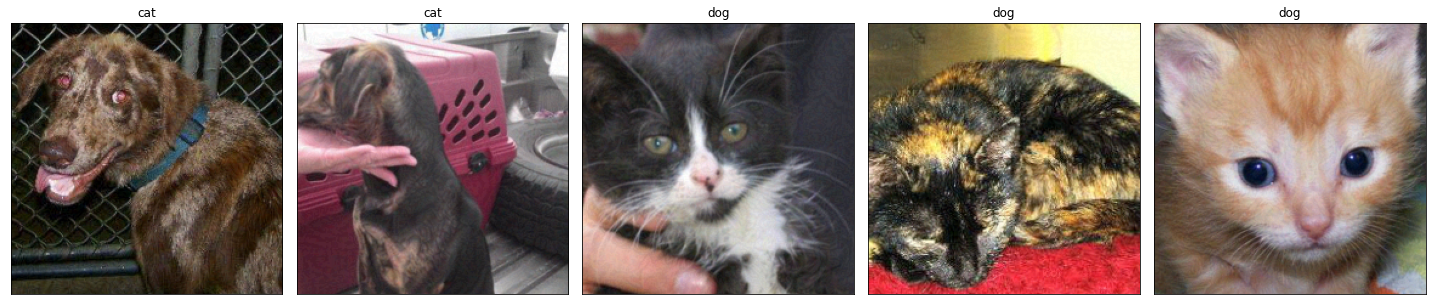

In [22]:
num_ex = 5
class_ = {0: 'cat', 1: 'dog'}
cnt = 0
plt.figure(figsize=(20,10))
with torch.no_grad():
  for i in range(1):
      for j in range(num_ex):
          cnt += 1
          plt.subplot(1,num_ex,cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          adv, lbl = adv_imgs[j]
          plt.title("{}".format(class_[lbl.item()]))
          adv = torch.tensor(adv)
          adv = denormalize(adv, *stats)
          adv = torch.squeeze(adv)
          plt.imshow(adv.permute(1,2,0).clamp(0,1))
  plt.tight_layout()
  plt.show()

# Generate TSNE Manifold

In [23]:
model = net

In [24]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return F.relu(x)

In [25]:
model.classifier[6] = Identity()

In [26]:
dl = adv_loader
outputs = np.empty((len(dl) + len(adv_imgs), 4096)) #+ len(adv_imgs)
labels = []
x=0

class_ = {0: 'cat', 1: 'dog'}


for img, label in dl:
    img = img.to(device)
    output = model(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(class_[label.item()])
    x += 1

for img, label in adv_imgs:
    img = img.to(device)
    output = model(img)
    outputs[x] = output.squeeze().tolist()
    labels.append(class_[label.item()])
    x += 1

print(outputs.shape)
print(len(labels))
print(x)

(8935, 4096)
8935
8935


In [27]:
time_start = time.time()
tsne2d = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne2d_results = tsne2d.fit_transform(outputs)
print('t-SNE done in {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8935 samples in 5.858s...
[t-SNE] Computed neighbors for 8935 samples in 687.492s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8935
[t-SNE] Computed conditional probabilities for sample 2000 / 8935
[t-SNE] Computed conditional probabilities for sample 3000 / 8935
[t-SNE] Computed conditional probabilities for sample 4000 / 8935
[t-SNE] Computed conditional probabilities for sample 5000 / 8935
[t-SNE] Computed conditional probabilities for sample 6000 / 8935
[t-SNE] Computed conditional probabilities for sample 7000 / 8935
[t-SNE] Computed conditional probabilities for sample 8000 / 8935
[t-SNE] Computed conditional probabilities for sample 8935 / 8935
[t-SNE] Mean sigma: 8.651858
[t-SNE] KL divergence after 250 iterations with early exaggeration: 162.111664
[t-SNE] KL divergence after 300 iterations: 7.740949
t-SNE done in 739.4800062179565 seconds


In [28]:
tsne2_subset = pd.DataFrame(columns=['tsne-2d-one', 'tsne-2d-two'])

tsne2_subset['tsne-2d-one'] = tsne2d_results[:,0]
tsne2_subset['tsne-2d-two'] = tsne2d_results[:,1]

print(tsne2_subset.head())

   tsne-2d-one  tsne-2d-two
0    -6.745705    -2.646261
1    -4.205594    11.015485
2     6.215150    -4.012118
3     6.846121    -1.158733
4    -3.515021     8.314751


<Figure size 720x720 with 0 Axes>

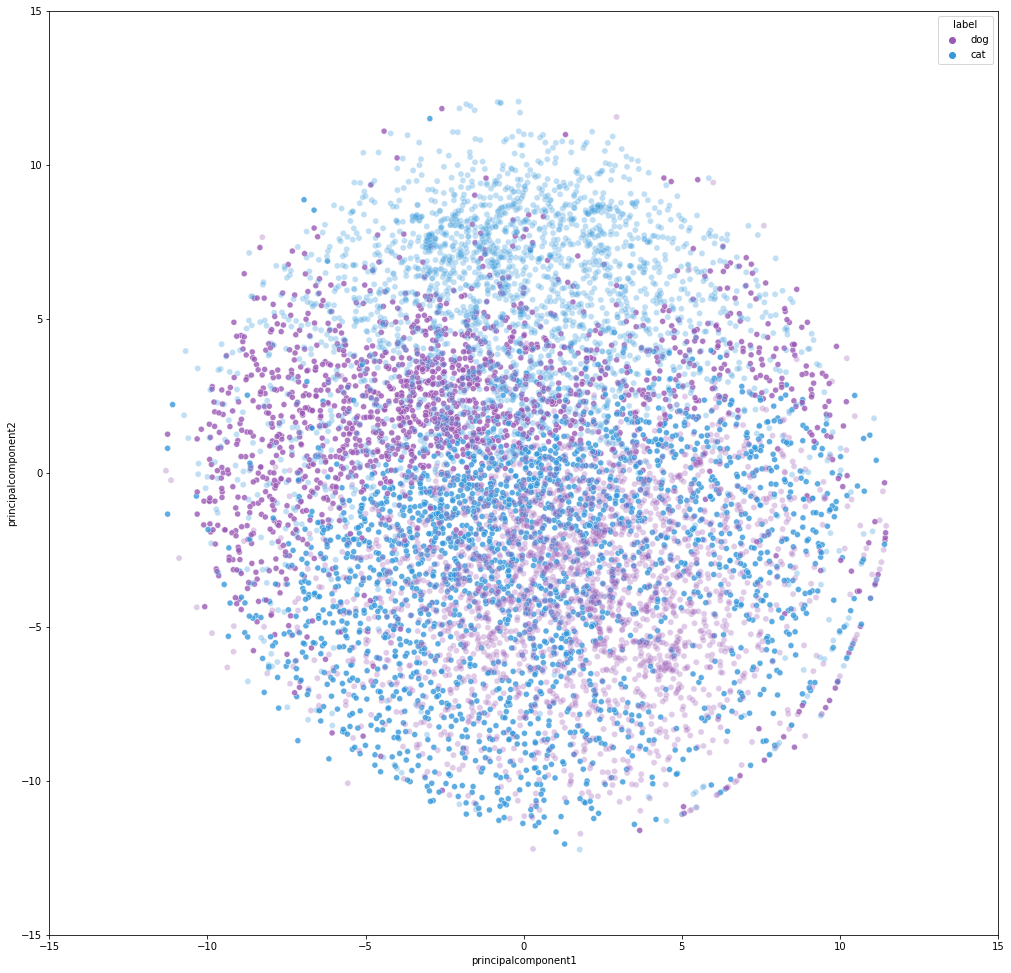

<Figure size 720x720 with 0 Axes>

In [32]:
principalDf = pd.concat([tsne2_subset,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]

flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
fig = plt.gcf()
# Change seaborn plot size
fig.set_size_inches(17, 17)
#Adversarial Images
sns.scatterplot(x='principalcomponent1', y='principalcomponent2', data=principalDf[5000:], hue='label', alpha =.8, legend=False)
#Original Images
sns.scatterplot(x='principalcomponent1', y='principalcomponent2', data=principalDf[:5000], hue='label', alpha =.3)
plt.ylim(-15,15)
plt.xlim(-15,15)
plt.figure(figsize=(10,10))

In [31]:
# flatui = ["#9b59b6", "#3498db", "orange"]
# sns.set_palette(flatui)
# sns.lmplot( x="principalcomponent1", y="principalcomponent2", data=principalDf[5000:], fit_reg=False, height=20,
#            hue='label', legend=True)
# plt.ylim(-15,15)
# plt.xlim(-15,15)

# plt.figure(figsize=(10,10))

# Generate PCA Manifold

(-25.0, 35.0)

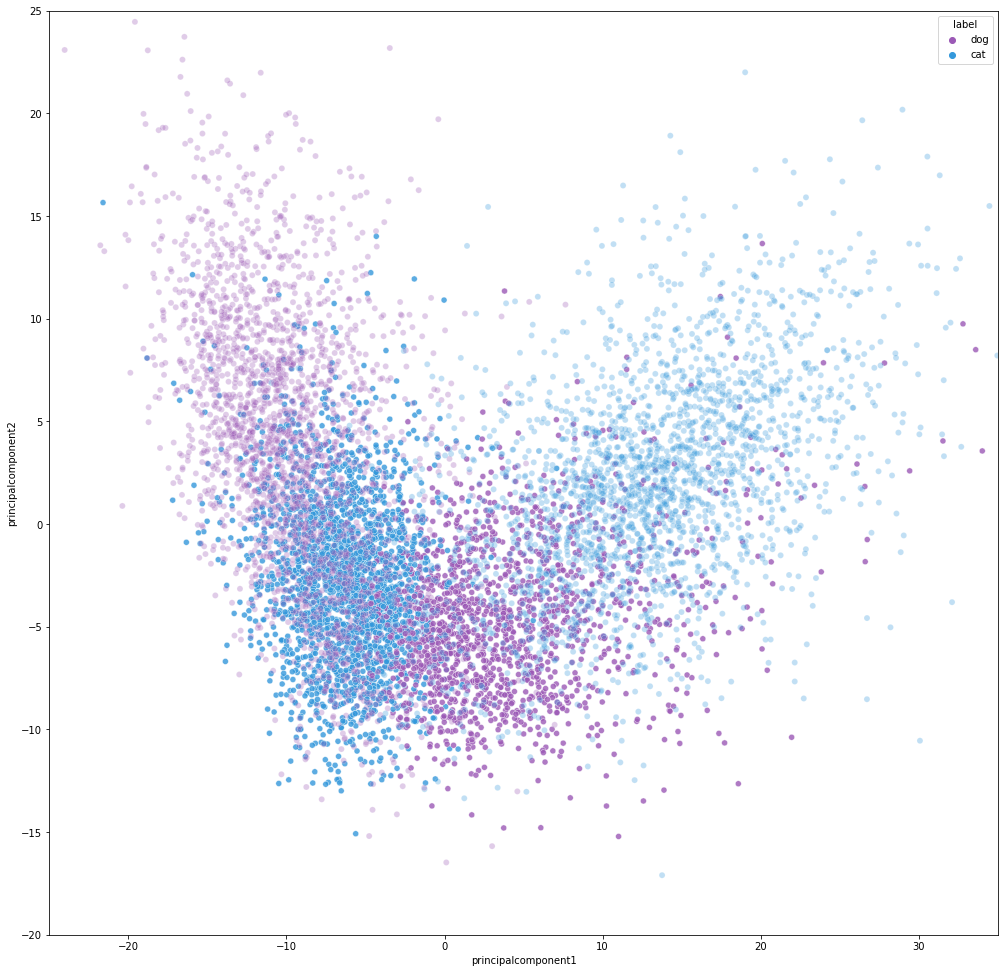

In [46]:
pca1 = PCA(n_components=2)
transformed_data = pca1.fit_transform(outputs)
dataframe = pd.DataFrame(data=transformed_data, columns=["principalcompnent1","principalcomponent2"])
principalDf = pd.concat([dataframe,pd.DataFrame(labels)],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = ["principalcomponent1", "principalcomponent2", "label"]
flatui = ["#9b59b6", "#3498db", "orange"]
sns.set_palette(flatui)
fig = plt.gcf()

# Change seaborn plot size
fig.set_size_inches(17, 17)
#Adversarial Images
sns.scatterplot(x='principalcomponent1', y='principalcomponent2', data=principalDf[5000:], hue='label', alpha =.8, legend=False)
#Original Images
sns.scatterplot(x='principalcomponent1', y='principalcomponent2', data=principalDf[:5000], hue='label', alpha =.3)

plt.ylim(-20,25)
plt.xlim(-25,35)